<a href="https://colab.research.google.com/github/anioki/ML_training_projects/blob/main/fish/fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download data

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              229KB  2021-06-19 20:05:51           7886  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4792  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1619  
dhruvildave/wikibooks-dataset                                 Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2261  
mathurinache/twitter-edge-nodes                               Tw

In [4]:
! kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:55<00:00, 42.2MB/s]
100% 3.24G/3.24G [00:55<00:00, 63.2MB/s]


In [ ]:
! mkdir data
! unzip a-large-scale-fish-dataset.zip -d data

In [6]:
import pandas as pd
import os

In [7]:
dir = '/content/data/Fish_Dataset/Fish_Dataset'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':          
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [8]:
df

,path,label
0,/content/data/Fish_Dataset/Fish_Dataset/Stripe...,Striped Red Mullet
1,/content/data/Fish_Dataset/Fish_Dataset/Stripe...,Striped Red Mullet
2,/content/data/Fish_Dataset/Fish_Dataset/Stripe...,Striped Red Mullet
3,/content/data/Fish_Dataset/Fish_Dataset/Stripe...,Striped Red Mullet
4,/content/data/Fish_Dataset/Fish_Dataset/Stripe...,Striped Red Mullet
...,...,...
8995,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
8996,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
8997,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel
8998,/content/data/Fish_Dataset/Fish_Dataset/Hourse...,Hourse Mackerel


#Data Preprocessing

In [9]:
df['label']=df['label'].astype('category')

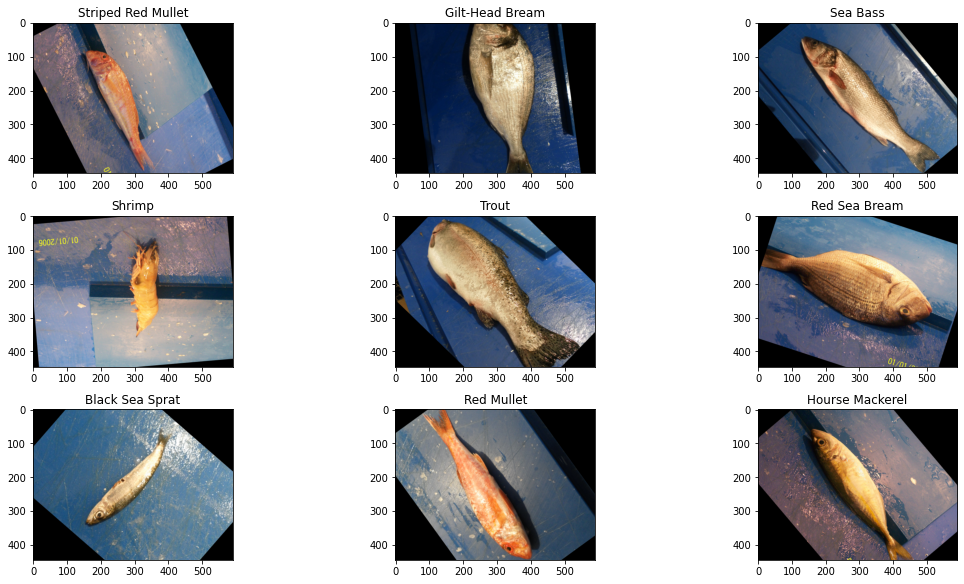

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,8), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['label'].unique():
    
    ax[j].imshow(plt.imread(df[df['label']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

In [11]:
class_names = df['label'].unique()
plt.imread(df['path'][1]).shape

(445, 590, 3)

In [12]:
from sklearn.model_selection import train_test_split
Train_set, test_set = train_test_split(df, test_size = 0.3, random_state = 42)
train_set, val_set = train_test_split(Train_set, test_size= 0.2, random_state = 42)

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
img_gen = ImageDataGenerator(preprocessing_function = preprocess_input, rescale=1/255)
img_size=(224, 224)
# img_gen cannot take in an array, so ensure the data that is been passed is a dataframe
train = img_gen.flow_from_dataframe(dataframe = train_set,
    x_col = 'path', 
    y_col ='label', 
    target_size = (224, 224),
    color_mode = 'rgb',
    class_mode = 'categorical',#the class mode here and that for the model_loss(when using sequential model)
                                    #should be the same
    batch_size = 32,
    shuffle = False 
)

test = img_gen.flow_from_dataframe(dataframe = test_set,
    x_col = 'path', 
    y_col ='label', 
    target_size =(224, 224),
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = 32,
    shuffle = False 
)


val = img_gen.flow_from_dataframe(dataframe = val_set,
    x_col = 'path', 
    y_col ='label', 
    target_size =(224, 224),
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = 32,
    shuffle = False 
)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


In [14]:
image_shape=test[0][0].shape[1:]
image_shape

(224, 224, 3)

In [15]:
test.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

#Model

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape = image_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 5

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(train, epochs=6, validation_data=val, verbose = 1)

Epoch 1/6
158/158 [==============================] - 93s 389ms/step - loss: 2.3858 - accuracy: 0.3563 - val_loss: 1.0292 - val_accuracy: 0.6532
Epoch 2/6
158/158 [==============================] - 59s 375ms/step - loss: 0.9487 - accuracy: 0.6522 - val_loss: 0.4188 - val_accuracy: 0.9008
Epoch 3/6
158/158 [==============================] - 59s 376ms/step - loss: 0.5749 - accuracy: 0.7819 - val_loss: 0.2684 - val_accuracy: 0.9341
Epoch 4/6
158/158 [==============================] - 59s 375ms/step - loss: 0.3880 - accuracy: 0.8508 - val_loss: 0.1447 - val_accuracy: 0.9619
Epoch 5/6
158/158 [==============================] - 59s 374ms/step - loss: 0.3156 - accuracy: 0.8849 - val_loss: 0.1647 - val_accuracy: 0.9532
Epoch 6/6
158/158 [==============================] - 59s 373ms/step - loss: 0.2584 - accuracy: 0.9022 - val_loss: 0.1145 - val_accuracy: 0.9698


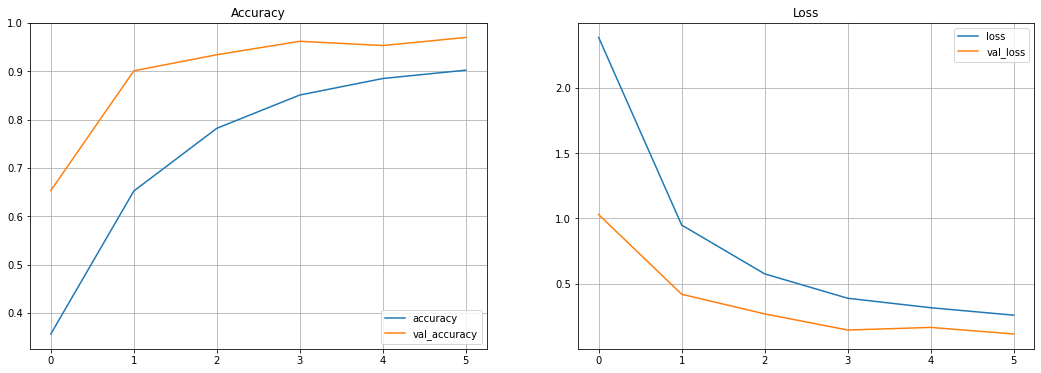

In [19]:
result=pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result['accuracy'], label='accuracy')
ax[0].plot(result['val_accuracy'], label='val_accuracy')
ax[0].set_title("Accuracy")
ax[0].legend(loc='lower right')
ax[0].grid()

ax[1].plot(result['loss'], label='loss')
ax[1].plot(result['val_loss'], label='val_loss')
ax[1].set_title("Loss")
ax[1].legend(loc='upper right')
ax[1].grid()

#Predict

In [20]:
import numpy as np

pred = model.predict(test)


In [21]:
pred = np.argmax(pred,axis = 1)
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]
from sklearn.metrics import classification_report, confusion_matrix # import metrics for evaluation

y_test = test_set.label # set y_test to the expected output

print(classification_report(y_test, pred2)) # print the classification report

                    precision    recall  f1-score   support

   Black Sea Sprat       0.96      1.00      0.98       314
   Gilt-Head Bream       0.96      0.98      0.97       326
   Hourse Mackerel       0.99      1.00      0.99       294
        Red Mullet       1.00      1.00      1.00       297
     Red Sea Bream       0.98      0.99      0.98       298
          Sea Bass       1.00      0.98      0.99       287
            Shrimp       0.99      0.99      0.99       288
Striped Red Mullet       0.98      0.96      0.97       300
             Trout       0.99      0.94      0.97       296

          accuracy                           0.98      2700
         macro avg       0.98      0.98      0.98      2700
      weighted avg       0.98      0.98      0.98      2700

